In [2]:
#Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install astroplan

     |████████████████████████████████| 134 kB 796 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for astroplan: filename=astroplan-0.8-py3-none-any.whl size=83258 sha256=2e5fd99e36edf4880787687c00a80e503bc6c1088b9f60c0da2335fad2f2e225
  Stored in directory: /Users/lyubing/Library/Caches/pip/wheels/2e/b0/14/4b1df814cb32ad11a009136db6e84c63bc17bc1205ad5dedfa
Successfully built astroplan


In [4]:
!{sys.executable} -m pip install pytest-astropy

     |████████████████████████████████| 414 kB 533 kB/s eta 0:00:01
     |████████████████████████████████| 200 kB 668 kB/s eta 0:00:01


============================= test session starts ==============================
platform darwin -- Python 3.9.12, pytest-7.1.1, pluggy-1.0.0
rootdir: /Users/lyubing
plugins: remotedata-0.4.0, anyio-3.5.0, hypothesis-6.76.0, asdf-2.13.0, mock-3.10.0, cov-4.1.0, filter-subpackage-0.1.2, astropy-header-0.2.2, doctestplus-0.12.1, astropy-0.10.0, openfiles-0.5.0, arraydiff-0.5.0
collected 84 items

../../../../opt/anaconda3/lib/python3.9/site-packages/astroplan/plots/tests/test_sky.py . [  1%]
.                                                                        [  2%]
../../../../opt/anaconda3/lib/python3.9/site-packages/astroplan/tests/test_constraints.py . [  3%]
.......................                                                  [ 30%]
../../../../opt/anaconda3/lib/python3.9/site-packages/astroplan/tests/test_moon.py . [ 32%]
                                                                         [ 32%]
../../../../opt/anaconda3/lib/python3.9/site-packages/astroplan/tests/test

<ExitCode.OK: 0>

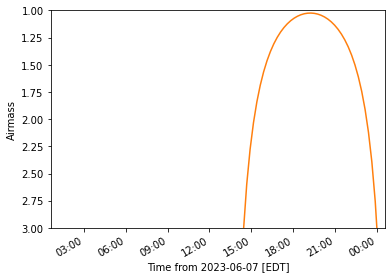

In [5]:
import astroplan
astroplan.test()

In [6]:
from astroplan.plots import plot_airmass

plot_airmass(target, observer, time)

NameError: name 'target' is not defined

In [7]:
from astroplan.plots import plot_airmass

plot_parallactic(target, observer, time)

NameError: name 'plot_parallactic' is not defined

/Users/lyubing/opt/anaconda3/lib/python3.9/site-packages/astroplan/plots/time_dependent.py:194: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot_date(timetoplot.plot_date, masked_airmass, label=target_name, **style_kwargs)


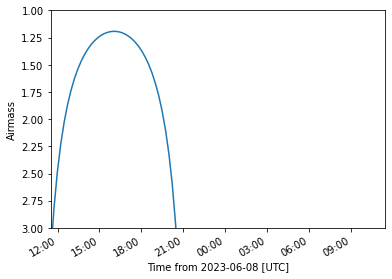

In [12]:
import matplotlib.pyplot as plt
from astropy.time import Time
from astroplan.plots import plot_airmass

observe_time = Time('2023-06-08 23:30:00')
target = FixedTarget.from_name('Mrk 1018')
apo = Observer.at_site('APO')
observer=apo
plot_airmass(target, observer, observe_time)
plt.show()

/Users/lyubing/opt/anaconda3/lib/python3.9/site-packages/astroplan/plots/time_dependent.py:194: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot_date(timetoplot.plot_date, masked_airmass, label=target_name, **style_kwargs)


<AxesSubplot:xlabel='Time from 2018-01-02 [UTC]', ylabel='Airmass'>

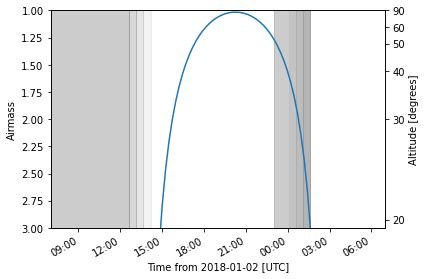

In [9]:
import matplotlib.pyplot as plt
from astropy.time import Time
from astroplan import FixedTarget, Observer
from astroplan.plots import plot_airmass

time = Time('2018-01-02 19:00')
target = FixedTarget.from_name('HD 189733')
apo = Observer.at_site('APO')
plot_airmass(target, apo, time, brightness_shading=True, altitude_yaxis=True)

<PolarAxesSubplot:>

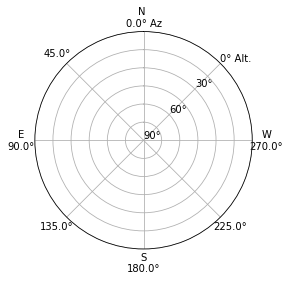

In [13]:
from astroplan.plots import plot_sky

plot_sky(target, observer, time)

https://astroplan.readthedocs.io/en/latest/tutorials/plots.html

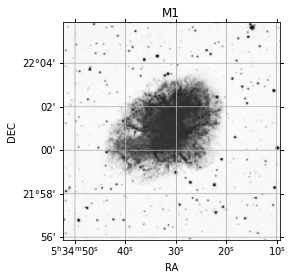

In [14]:
from astroplan.plots import plot_finder_image
from astroplan import FixedTarget
import matplotlib.pyplot as plt

messier1 = FixedTarget.from_name("M1")
ax, hdu = plot_finder_image(messier1)
plt.show()

# SimpleScheduler

In [15]:
from astroplan.scheduling import Scheduler, Scorer
from astroplan.utils import time_grid_from_range
from astroplan.constraints import AltitudeConstraint
from astropy import units as u
import numpy as np

class SimpleScheduler(Scheduler):
    """
    schedule blocks randomly
    """
    def __init__(self, *args, **kwargs):
        super(SimpleScheduler, self).__init__(*args, **kwargs)

    def _make_schedule(self, blocks):
        # gather all the constraints on each block into a single attribute
        for b in blocks:
            if b.constraints is None:
                b._all_constraints = self.constraints
            else:
                b._all_constraints = self.constraints + b.constraints

            # to make sure the Scorer has some constraint to work off of
            # and to prevent scheduling of targets below the horizon
            if b._all_constraints is None:
                b._all_constraints = [AltitudeConstraint(min=0*u.deg)]
                b.constraints = [AltitudeConstraint(min=0*u.deg)]
            elif not any(isinstance(c, AltitudeConstraint) for c in b._all_constraints):
                b._all_constraints.append(AltitudeConstraint(min=0*u.deg))
                if b.constraints is None:
                    b.constraints = [AltitudeConstraint(min=0*u.deg)]
                else:
                    b.constraints.append(AltitudeConstraint(min=0*u.deg))
            b.observer = self.observer

        # before we can schedule, we need to know where blocks meet the constraints
        scorer = Scorer(blocks, self.observer, self.schedule,
                        global_constraints=self.constraints)
        score_array = scorer.create_score_array(self.time_resolution)
        # now we have an array of the scores for the blocks at intervals of
        # ``time_resolution``. The scores range from zero to one, some blocks may have
        # higher scores than others, but we only care if they are greater than zero

        # we want to start from the beginning and start scheduling
        start_time = self.schedule.start_time
        current_time = start_time
        while current_time < self.schedule.end_time:
            scheduled = False
            i=0
            while i < len(blocks) and scheduled is False:
                block = blocks[i]
                # the schedule starts with only 1 slot
                if len(self.schedule.slots) == 1:
                    test_time = current_time
                # when a block is inserted, the number of slots increases
                else:
                    # a test transition between the last scheduled block and this one
                    transition = self.transitioner(schedule.observing_blocks[-1],
                                                   block, current_time, self.observer)
                    test_time = current_time + transition.duration
                # how many time intervals are we from the start
                start_idx = int((test_time - start_time)/self.time_resolution)
                duration_idx = int(block.duration/self.time_resolution)
                # if any score during the block's duration would be 0, reject it
                if any(score_array[i][start_idx:start_idx+duration_idx] == 0):
                    i +=1
                # if all of the scores are >0, accept and schedule it
                else:
                    if len(self.schedule.slots) >1:
                        self.schedule.insert_slot(current_time, transition)
                    self.schedule.insert_slot(test_time, block)
                    # advance the time and remove the block from the list
                    current_time = test_time + block.duration
                    scheduled = True
                    blocks.remove(block)
            # if every block failed, progress the time
            if i == len(blocks):
                current_time += self.gap_time
        return schedule

In [17]:
Observer.at_site?

In [20]:
import astropy
astropy.coordinates.EarthLocation.get_site_names()

['',
 '',
 '',
 'ALMA',
 'AO',
 'ARCA',
 'ASKAP',
 'ATA',
 'ATST',
 'Allen Telescope Array',
 'Anderson Mesa',
 'Anglo-Australian Observatory',
 'Apache Point',
 'Apache Point Observatory',
 'Arecibo',
 'Arecibo Observatory',
 'Atacama Large Millimeter Array',
 'Australian Square Kilometre Array Pathfinder',
 'BAO',
 'BBSO',
 'Beijing XingLong Observatory',
 'Black Moshannon Observatory',
 'CAHA',
 'CAHA',
 'CHARA',
 'CHIME',
 'Canada-France-Hawaii Telescope',
 'Catalina Observatory',
 'Cerro Pachon',
 'Cerro Paranal',
 'Cerro Tololo',
 'Cerro Tololo Interamerican Observatory',
 'Cima Ekar Observing Station',
 'DCT',
 'DKIST',
 'DRAO',
 'DRAO 26m Telescope',
 'Discovery Channel Telescope',
 'Dominion Astrophysical Observatory',
 'Dominion Radio Astrophysical Observatory',
 'Effelsberg',
 'FAST',
 'G1',
 'GBT',
 'GEO',
 'GEO_600',
 'GMRT',
 'Gemini South',
 'Green Bank Observatory',
 'Green Bank Telescope',
 'H1',
 'HALO',
 'HET',
 'Hale Telescope',
 'Haleakala Observatories',
 'Happy J

/Users/lyubing/opt/anaconda3/lib/python3.9/site-packages/astroplan/plots/time_dependent.py:194: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot_date(timetoplot.plot_date, masked_airmass, label=target_name, **style_kwargs)
/Users/lyubing/opt/anaconda3/lib/python3.9/site-packages/astroplan/plots/time_dependent.py:194: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot_date(timetoplot.plot_date, masked_airmass, label=target_name, **style_kwargs)


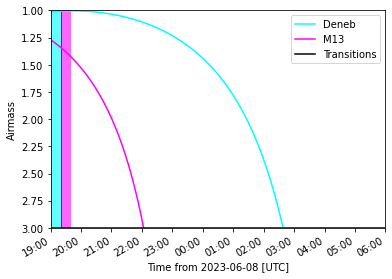

In [23]:
from astroplan.constraints import AtNightConstraint
from astroplan.scheduling import Schedule, ObservingBlock
from astroplan import FixedTarget, Observer, Transitioner
from astropy.time import Time

# Initialize the observer and targets, and create observing blocks
apo = Observer.at_site('Beijing XingLong Observatory')
deneb = FixedTarget.from_name('Deneb')
m13 = FixedTarget.from_name('M13')
blocks = [ObservingBlock(deneb, 20*u.minute, 0)]
blocks.append(ObservingBlock(m13, 20*u.minute, 0))

# For a telescope that can slew at a rate of 2 degrees/second
transitioner = Transitioner(slew_rate=2*u.deg/u.second)

# Schedule the observing blocks using the simple scheduler
schedule = Schedule(Time('2023-06-08 19:00'), Time('2023-06-09 06:00'))
scheduler = SimpleScheduler(observer = apo, transitioner = transitioner,
                                constraints = [])
scheduler(blocks, schedule)

# Plot the created schedule
import matplotlib.pyplot as plt
from astroplan.plots import plot_schedule_airmass
plot_schedule_airmass(schedule)
plt.legend()
plt.show()

In [27]:
Time('2023-06-07 19:00').mjd

60102.791666666664

In [26]:
Time('2023-06-07T19:00').mjd

60102.791666666664

In [28]:
t1 = Time(50100.0, scale='tt', format='mjd')
t2 = Time('2010-01-01 00:00:00', scale='utc')

In [29]:
Time([t1, t2]) 

<Time object: scale='tt' format='mjd' value=[50100.         55197.00076602]>

In [31]:
from datetime import datetime
from astropy.time import Time

nt = Time.now()
ut = Time(datetime.utcnow(), scale='utc')

In [32]:
nt

<Time object: scale='utc' format='datetime' value=2023-06-07 08:45:38.442397>

In [33]:
ut

<Time object: scale='utc' format='datetime' value=2023-06-07 08:45:38.443505>

In [36]:
t = Time('2023-06-07 00:00:00', format='iso', scale='utc')

In [37]:
t.mjd

60102.0

In [38]:
t.iso  

'2023-06-07 00:00:00.000'

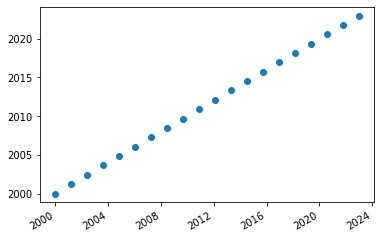

In [40]:
import matplotlib.pyplot as plt  
jyear = np.linspace(2000, 2023, 20)  
t = Time(jyear, format='jyear')  
plt.plot_date(t.plot_date, jyear)  
plt.gcf().autofmt_xdate()  # orient date labels at a slant  
plt.draw()  